In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
import os

In [2]:
# Classifying the different languages audio files into different folders using regex or regular expression
import os
import shutil
import re

# Directory containing audio files
source_dir = 'C:/Users/myada/Downloads/archive(1)/train/train/'

# Destination directory for storing classified files
destination_dir = 'C:/Users/myada/Downloads/archive(1)/Destination/'

# Regular expressions for different language codes
language_patterns = {
    'en': re.compile('^en', re.IGNORECASE),  # English
    'es': re.compile('^es', re.IGNORECASE),  # spanish
    'de': re.compile('^de', re.IGNORECASE),  # German
    
}

# Function to classify audio files based on language code in filename
def classify_and_store_audio_by_language(filename, destination_dir):
    for lang_code, pattern in language_patterns.items():
        if re.match(pattern, os.path.basename(filename)):
            lang_dir = os.path.join(destination_dir, lang_code)
            os.makedirs(lang_dir, exist_ok=True)
            shutil.copy(filename, lang_dir)
            return lang_code
    return 'unknown'  # If no match found

# Iterate over audio files in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith('.flac'): 
        source_file_path = os.path.join(source_dir, filename)
        lang_code = classify_and_store_audio_by_language(source_file_path, destination_dir)
        print(f"The audio file '{filename}' belongs to the language '{lang_code}'.")


In [3]:
# Defining function for feature extraction which returns values of  Mel-frequency cepstral coefficients
def feature_extraction(file_path):
    x,sample_rate=librosa.load(file_path)
    mfcc=np.mean(librosa.feature.mfcc(y=x,sr=sample_rate,n_mfcc=128*2).T,axis=0)
    return mfcc

In [4]:
# Visualizing the data using a single audio file
audio_file=glob("C:/Users/myada/Downloads/archive(1)/Destination/en/*.flac")
ipd.Audio(audio_file[0])

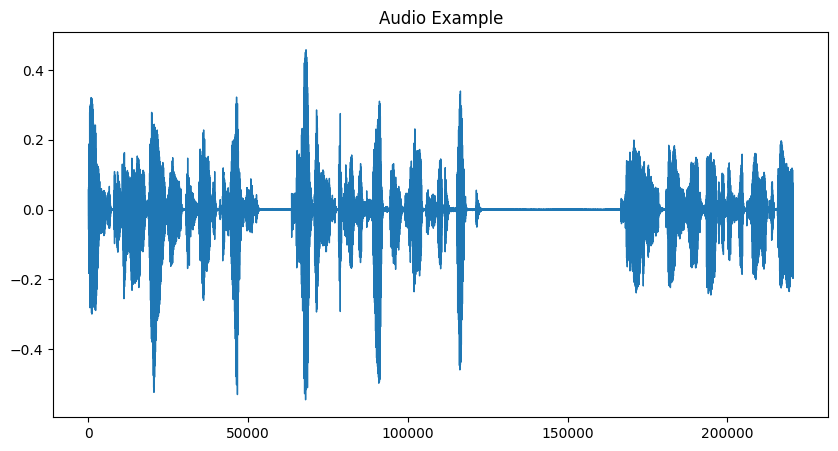

In [5]:
y,sr=librosa.load(audio_file[0])
pd.Series(y).plot(figsize=(10,5),lw=1,title="Audio Example")

plt.show()


In [6]:
D=librosa.stft(y)
s_db=librosa.amplitude_to_db(np.abs(D),ref=np.max)
s_db.shape

(1025, 431)

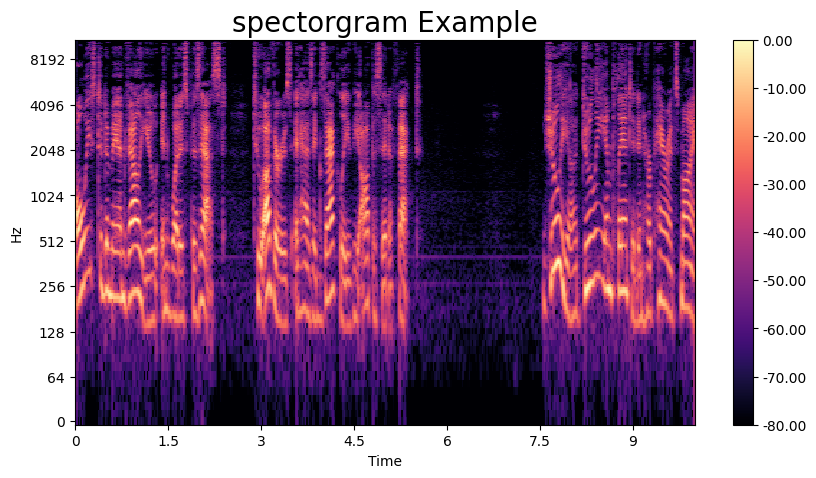

In [7]:
# The transformed audio data
fig,ax=plt.subplots(figsize=(10,5))
img=librosa.display.specshow(s_db,x_axis="time",y_axis="log",ax=ax)
ax.set_title("spectorgram Example",fontsize=20)
fig.colorbar(img,ax=ax,format=f'%0.2f')
plt.show()

In [8]:
S=librosa.feature.melspectrogram(y=y,sr=sr,n_mels=128*2,)
S_db_mel=librosa.amplitude_to_db(S,ref=np.max)
S.shape

(256, 431)

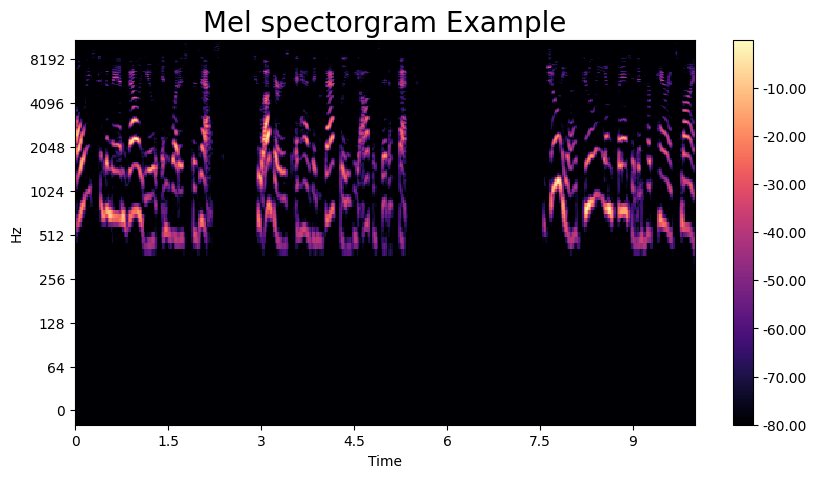

In [9]:
fig,ax=plt.subplots(figsize=(10,5))
img=librosa.display.specshow(S_db_mel,x_axis="time",y_axis="log",ax=ax)
ax.set_title("Mel spectorgram Example",fontsize=20)
fig.colorbar(img,ax=ax,format=f'%0.2f')
plt.show()

In [10]:
# Extracting the features from the different audio language folder and storint in dictionary
# Taking 2500 audion samples from each language
mfcc_English={}
i=0

directory = "C:/Users/myada/Downloads/archive(1)/Destination/en/"
for audio in os.listdir(directory):
    if i<2500:
        audio_path=directory+audio
        mfcc_English[audio_path]=feature_extraction(audio_path)
        i=i+1
mfcc_Spanish={}
i=0

directory = "C:/Users/myada/Downloads/archive(1)/Destination/es/"
for audio in os.listdir(directory):
    if i<2500:
        audio_path=directory+audio
        mfcc_Spanish[audio_path]=feature_extraction(audio_path)
        i=i+1
mfcc_German={}
i=0

directory = "C:/Users/myada/Downloads/archive(1)/Destination/de/"
for audio in os.listdir(directory):
    if i<2500:
        audio_path=directory+audio
        mfcc_German[audio_path]=feature_extraction(audio_path)
        i=i+1

In [11]:
# Creating a DataFrame 
import random

# Combine dictionaries
combined_features = {}

for lang, features in [("English", mfcc_English), ("German", mfcc_German), ("Spanish", mfcc_Spanish)]:
    for audio_path, feature in features.items():
        combined_features[audio_path] = {"features": feature, "language": lang}

# Convert to DataFrame
df = pd.DataFrame.from_dict(combined_features, orient='index')

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
print("Number of samples of Spanish",len(mfcc_Spanish))
print("Number of samples of English",len(mfcc_English))
print("Number of samples of German",len(mfcc_German))
df.head()


Number of samples of Spanish 2500
Number of samples of English 2500
Number of samples of German 2500


,features,language
0,"[-369.91205, 65.73892, 3.6230583, 22.438414, 6...",English
1,"[-386.2649, 72.64546, 9.941724, 29.712084, 14....",English
2,"[-320.86215, 142.65472, -12.108527, 18.711994,...",German
3,"[-225.58257, 109.02058, -30.145918, 8.490567, ...",Spanish
4,"[-350.36508, 75.93236, -15.453374, 24.186872, ...",English


In [13]:
x = np.array(df['features'].tolist())

In [14]:
y = np.array(df['language'].tolist())

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [16]:
# Splitting the Data for training and testing purpose
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6000, 128) (1500, 128) (6000, 3) (1500, 3)


In [17]:
unq = np.unique(df['language'])
print(unq)

['English' 'German' 'Spanish']


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout

In [19]:
from keras.optimizers import Adam
from keras.regularizers import l2

In [167]:
# Building a Simple Neural Network Model
model =Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(128,)))
model.add(BatchNormalization())

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
 

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
learning_rate = 0.01  # Example learning rate

# Create the SGD optimizer with the specified learning rate
sgd_optimizer = SGD(learning_rate=learning_rate)


cnn_model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_22 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_65 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_23 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_66 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_24 (Ba  (None, 128)             

In [168]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

In [169]:
arn =model.fit(X_train,y_train,epochs=10,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/10
375/375 [==============================] - 4s 4ms/step - loss: 0.3726 - accuracy: 0.8605 - precision: 0.8739 - recall: 0.8467 - auc: 0.9643 - val_loss: 0.1171 - val_accuracy: 0.9567 - val_precision: 0.9623 - val_recall: 0.9527 - val_auc: 0.9962
Epoch 2/10
375/375 [==============================] - 1s 3ms/step - loss: 0.1691 - accuracy: 0.9422 - precision: 0.9455 - recall: 0.9393 - auc: 0.9911 - val_loss: 0.0321 - val_accuracy: 0.9873 - val_precision: 0.9873 - val_recall: 0.9873 - val_auc: 0.9996
Epoch 3/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0984 - accuracy: 0.9665 - precision: 0.9679 - recall: 0.9657 - auc: 0.9966 - val_loss: 0.0499 - val_accuracy: 0.9813 - val_precision: 0.9813 - val_recall: 0.9813 - val_auc: 0.9993
Epoch 4/10
375/375 [==============================] - 1s 3ms/step - loss: 0.0990 - accuracy: 0.9675 - precision: 0.9685 - recall: 0.9673 - auc: 0.9959 - val_loss: 0.0229 - val_accuracy: 0.9947 - val_precision: 0.9947 - val_recall: 0

In [189]:
model.evaluate(X_train,y_train)

188/188 [==============================] - 0s 1ms/step - loss: 0.0800 - accuracy: 0.9728 - precision: 0.9731 - recall: 0.9725 - auc: 0.9975


[0.08001472055912018,
 0.9728333353996277,
 0.973148763179779,
 0.9725000262260437,
 0.9975340366363525]

In [190]:
model.evaluate(X_test, y_test)

47/47 [==============================] - 0s 1ms/step - loss: 0.0778 - accuracy: 0.9760 - precision: 0.9760 - recall: 0.9753 - auc: 0.9977


[0.0778384581208229,
 0.9760000109672546,
 0.9759839773178101,
 0.9753333330154419,
 0.9977089762687683]

In [199]:
#Testing it by taking the audio  file from dataset
Testing_Audio=glob("C:/Users/myada/Downloads/archive(1)/Destination/en/*.flac")

In [200]:
ipd.Audio(Testing_Audio[10])

In [201]:
# Caculating the mfcc values
X,sample_rate=librosa.load(Testing_Audio[10])
mfcc=np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=12882).T,axis=0)


In [203]:
# Making the predictions
# z is the mfcc values for the English language with noise
labels = ['English', 'German', 'Spanish']
print(labels)
z=mfcc
z = np.reshape(z, (1, 128))
prediction =model.predict(z)
print(prediction)

['English', 'German', 'Spanish']
1/1 [==============================] - 0s 18ms/step
[[9.9996126e-01 3.8690941e-05 2.6337526e-08]]


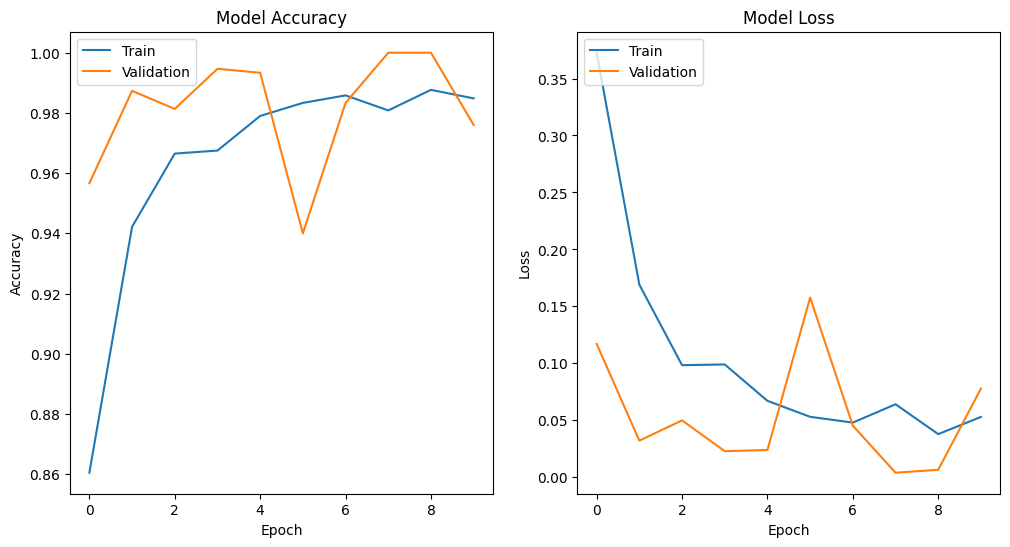

In [204]:
# Ploting the data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(arn.history['accuracy'])
plt.plot(arn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(arn.history['loss'])
plt.plot(arn.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [30]:
from tensorflow.keras.layers import LSTM

In [31]:
x.shape[1:3]

(128,)

In [32]:
# Building the Long-short Term Memory Model
lstm = Sequential()

# Adding the first LSTM layer with Batch Normalization
lstm.add(LSTM(256, input_shape=(128,1), return_sequences=False))
lstm.add(BatchNormalization())



# Add Dense layers
lstm.add(Dense(256, activation='relu'))
lstm.add(BatchNormalization())

lstm.add(Dense(256, activation='relu'))
lstm.add(BatchNormalization())

lstm.add(Dense(256, activation='relu'))
lstm.add(BatchNormalization())

lstm.add(Dense(256, activation='relu'))
lstm.add(BatchNormalization())


# Output layer
lstm.add(Dense(3, activation='softmax'))

lstm.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_8 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_9 (Bat  (None, 256)              

In [33]:
#fitting the model
ls=lstm.fit(X_train,y_train,epochs=30,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/30
375/375 [==============================] - 26s 64ms/step - loss: 1.0932 - accuracy: 0.4878 - precision: 0.5131 - recall: 0.3865 - auc: 0.6753 - val_loss: 1.0321 - val_accuracy: 0.5153 - val_precision: 0.5822 - val_recall: 0.3800 - val_auc: 0.6813
Epoch 2/30
375/375 [==============================] - 24s 63ms/step - loss: 0.8790 - accuracy: 0.5895 - precision: 0.6576 - recall: 0.4913 - auc: 0.7815 - val_loss: 1.4416 - val_accuracy: 0.4740 - val_precision: 0.4905 - val_recall: 0.3967 - val_auc: 0.6606
Epoch 3/30
375/375 [==============================] - 24s 64ms/step - loss: 0.8111 - accuracy: 0.6193 - precision: 0.6874 - recall: 0.5293 - auc: 0.8139 - val_loss: 1.4038 - val_accuracy: 0.4127 - val_precision: 0.4271 - val_recall: 0.3380 - val_auc: 0.5806
Epoch 4/30
375/375 [==============================] - 24s 64ms/step - loss: 0.7486 - accuracy: 0.6622 - precision: 0.7218 - recall: 0.5787 - auc: 0.8452 - val_loss: 0.9306 - val_accuracy: 0.5927 - val_precision: 0.6242 - val_r

In [205]:
lstm.evaluate(X_train, y_train)

188/188 [==============================] - 7s 37ms/step - loss: 0.4557 - accuracy: 0.8592 - precision: 0.8646 - recall: 0.8512 - auc: 0.9619


[0.455696165561676,
 0.85916668176651,
 0.8645674586296082,
 0.8511666655540466,
 0.9618854522705078]

In [206]:
lstm.evaluate(X_test, y_test)

47/47 [==============================] - 2s 37ms/step - loss: 0.4391 - accuracy: 0.8607 - precision: 0.8653 - recall: 0.8567 - auc: 0.9639


[0.4390590786933899,
 0.8606666922569275,
 0.8653198480606079,
 0.8566666841506958,
 0.963922381401062]

In [207]:
ann_preds = np.argmax(model.predict(X_test), axis = 1)

47/47 [==============================] - 0s 1ms/step


In [208]:
lstm_preds = np.argmax(lstm.predict(X_test), axis =  1)

47/47 [==============================] - 2s 36ms/step


In [221]:
Testing_Audio=glob("C:/Users/myada/Downloads/archive(1)/Destination/es/*.flac")

In [222]:
ipd.Audio(Testing_Audio[10])

In [223]:
# Caculating the mfcc values
X,sample_rate=librosa.load(Testing_Audio[10])
mfcc=np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=128*2).T,axis=0)


In [224]:
# Making the predictions
# Z is the mfcc values for Spanish it contains Noise data audio
print(labels)
z=mfcc
z = np.reshape(z, (1, 128))
prediction =lstm.predict(z)
print(prediction)

['English', 'German', 'Spanish']
1/1 [==============================] - 0s 26ms/step
[[3.7676269e-05 6.8541095e-03 9.9310827e-01]]


In [226]:
from sklearn.metrics import confusion_matrix


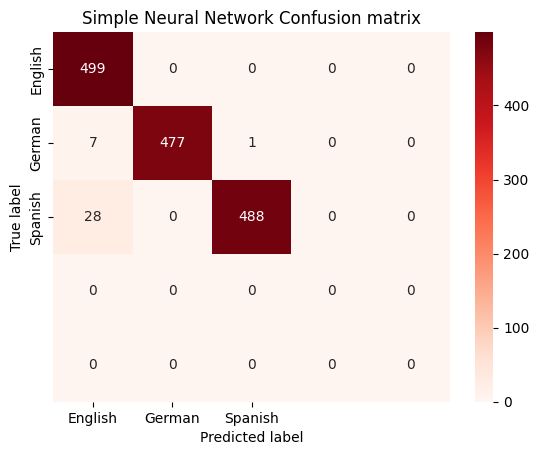

In [227]:
cm = confusion_matrix(np.argmax(y_test, axis=1), ann_preds, labels=range(5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Simple Neural Network Confusion matrix')
plt.show()

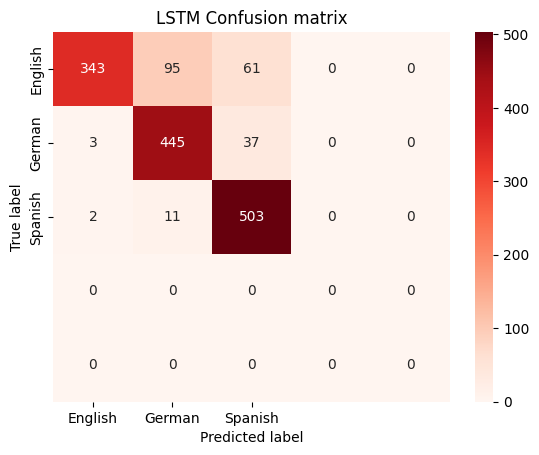

In [228]:
cmm= confusion_matrix(np.argmax(y_test, axis=1), lstm_preds, labels=range(5))

sns.heatmap(cmm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LSTM Confusion matrix')
plt.show()

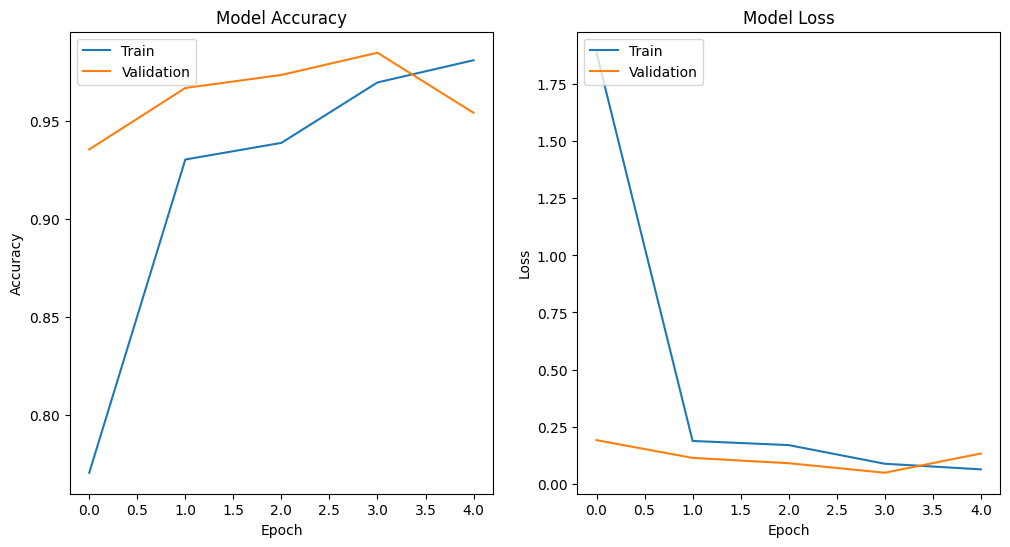

In [229]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ls.history['accuracy'])
plt.plot(ls.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ls.history['loss'])
plt.plot(ls.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [47]:
# Building a simple RNN model
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, BatchNormalization

# Defining the RNN model
rnn_model = Sequential()

# RNN layer with Batch Normalization
rnn_model.add(SimpleRNN(256, input_shape=(128, 1), return_sequences=False))
rnn_model.add(BatchNormalization())

# Dense layers
rnn_model.add(Dense(256, activation='relu'))
rnn_model.add(BatchNormalization())

rnn_model.add(Dense(256, activation='relu'))
rnn_model.add(BatchNormalization())

# Output layer
rnn_model.add(Dense(3, activation='softmax'))

# Compile the model
rnn_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Print model summary
rnn_model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_13 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_14 (Ba  (None, 256)              

In [48]:
ls=rnn_model.fit(X_train,y_train,epochs=10,batch_size=16,validation_data=(X_test,y_test))


Epoch 1/10
375/375 [==============================] - 10s 24ms/step - loss: 1.1533 - accuracy: 0.3580 - precision: 0.3768 - recall: 0.1040 - auc: 0.5343 - val_loss: 1.3405 - val_accuracy: 0.3387 - val_precision: 0.3739 - val_recall: 0.2747 - val_auc: 0.5007
Epoch 2/10
375/375 [==============================] - 9s 23ms/step - loss: 1.1345 - accuracy: 0.3600 - precision: 0.3869 - recall: 0.0967 - auc: 0.5373 - val_loss: 1.4843 - val_accuracy: 0.2853 - val_precision: 0.2593 - val_recall: 0.1487 - val_auc: 0.4817
Epoch 3/10
375/375 [==============================] - 9s 23ms/step - loss: 1.1234 - accuracy: 0.3720 - precision: 0.3927 - recall: 0.0952 - auc: 0.5451 - val_loss: 1.1404 - val_accuracy: 0.3567 - val_precision: 0.3429 - val_recall: 0.2073 - val_auc: 0.5431
Epoch 4/10
375/375 [==============================] - 9s 23ms/step - loss: 1.1270 - accuracy: 0.3653 - precision: 0.3830 - recall: 0.0887 - auc: 0.5380 - val_loss: 1.1810 - val_accuracy: 0.3653 - val_precision: 0.3329 - val_reca

In [230]:
rnn_model.evaluate(X_train, y_train)

188/188 [==============================] - 2s 12ms/step - loss: 1.0865 - accuracy: 0.3910 - precision: 0.4892 - recall: 0.0790 - auc: 0.5932


[1.0865325927734375,
 0.39100000262260437,
 0.4891640841960907,
 0.07900000363588333,
 0.5932271480560303]

In [231]:
rnn_model.evaluate(X_test, y_test)

47/47 [==============================] - 1s 12ms/step - loss: 1.0731 - accuracy: 0.3840 - precision: 0.4979 - recall: 0.0807 - auc: 0.6020


[1.0731439590454102,
 0.3840000033378601,
 0.49794238805770874,
 0.0806666687130928,
 0.6019705533981323]

In [232]:
rnn_preds = np.argmax(rnn_model.predict(X_test), axis =  1)

47/47 [==============================] - 1s 12ms/step


In [233]:
Testing_Audio=glob("C:/Users/myada/Downloads/archive(1)/Destination/en/*.flac")
ipd.Audio(Testing_Audio[10])


In [234]:
# Caculating the mfcc values
X,sample_rate=librosa.load(Testing_Audio[10])
mfcc=np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=128).T,axis=0)

In [235]:
# Making the predictions
# Z is the mfcc values for English it contains Noise data audio
print(labels)
z=mfcc
z = np.reshape(z, (1, 128))
prediction =rnn_model.predict(z)
print(prediction)

['English', 'German', 'Spanish']
1/1 [==============================] - 0s 21ms/step
[[0.4137311  0.3654658  0.22080317]]


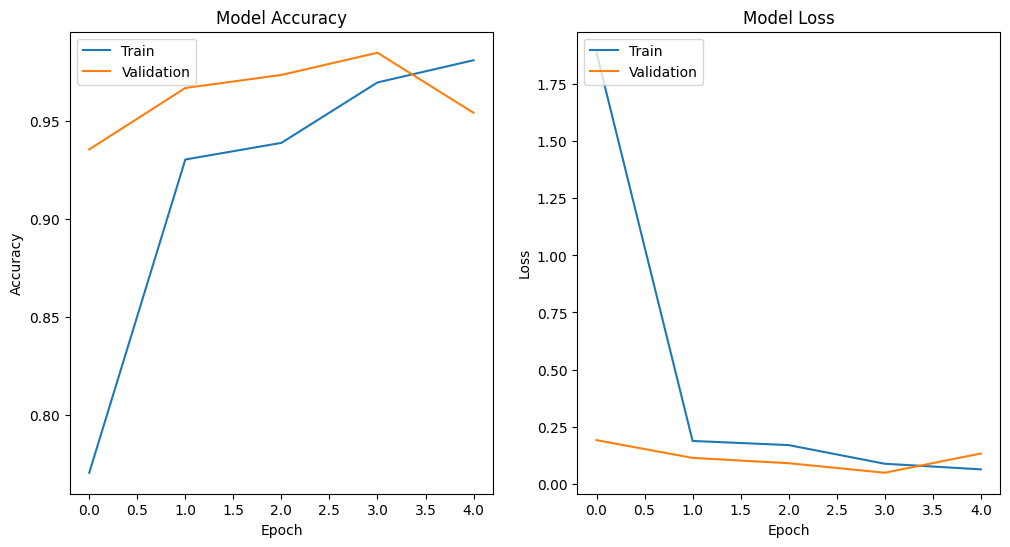

In [236]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ls.history['accuracy'])
plt.plot(ls.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ls.history['loss'])
plt.plot(ls.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

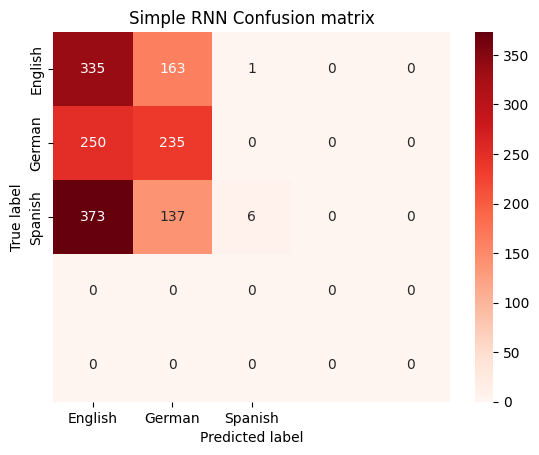

In [237]:
cm = confusion_matrix(np.argmax(y_test, axis=1), rnn_preds, labels=range(5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Simple RNN Confusion matrix')
plt.show()

In [176]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed

# Define the CRNN model
crnn_model = Sequential()

# Convolutional layers
crnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 1)))
crnn_model.add(MaxPooling1D(pool_size=2))
crnn_model.add(Conv1D(128, kernel_size=3, activation='relu'))
crnn_model.add(MaxPooling1D(pool_size=2))

# Recurrent layer
crnn_model.add(TimeDistributed(Flatten()))  # Flatten output of convolutional layers
crnn_model.add(LSTM(64, activation='relu', return_sequences=True))

# Dense layers
crnn_model.add(Flatten())
crnn_model.add(Dense(128, activation='relu'))
crnn_model.add(Dense(3, activation='softmax'))

# Compile the model
learning_rate = 0.01  # Example learning rate

# Create the SGD optimizer with the specified learning rate
Adam_optimizer = Adam(learning_rate=learning_rate)


crnn_model.compile(optimizer=Adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Print model summary
crnn_model.summary()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 126, 64)           256       
                                                                 
 max_pooling1d_44 (MaxPooli  (None, 63, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_46 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 max_pooling1d_45 (MaxPooli  (None, 30, 128)           0         
 ng1D)                                                           
                                                                 
 time_distributed_9 (TimeDi  (None, 30, 128)           0         
 stributed)                                                      
                                                     

In [238]:
ls=crnn_model.fit(X_train,y_train,epochs=5,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0735 - accuracy: 0.9767 - precision: 0.9783 - recall: 0.9758 - auc: 0.9976 - val_loss: 0.1546 - val_accuracy: 0.9507 - val_precision: 0.9561 - val_recall: 0.9427 - val_auc: 0.9930
Epoch 2/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0784 - accuracy: 0.9765 - precision: 0.9783 - recall: 0.9758 - auc: 0.9967 - val_loss: 0.0965 - val_accuracy: 0.9727 - val_precision: 0.9740 - val_recall: 0.9727 - val_auc: 0.9944
Epoch 3/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0557 - accuracy: 0.9818 - precision: 0.9828 - recall: 0.9812 - auc: 0.9982 - val_loss: 0.0406 - val_accuracy: 0.9827 - val_precision: 0.9846 - val_recall: 0.9827 - val_auc: 0.9995
Epoch 4/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0933 - accuracy: 0.9692 - precision: 0.9705 - recall: 0.9665 - auc: 0.9964 - val_loss: 0.1707 - val_accuracy: 0.9607 - val_precision: 0.9612 - val_recall: 0

In [239]:
crnn_model.evaluate(X_train, y_train)

188/188 [==============================] - 1s 5ms/step - loss: 0.0946 - accuracy: 0.9690 - precision: 0.9709 - recall: 0.9685 - auc: 0.9962


[0.0945906862616539,
 0.968999981880188,
 0.9709272980690002,
 0.968500018119812,
 0.9962123036384583]

In [240]:
crnn_model.evaluate(X_test, y_test)

47/47 [==============================] - 0s 6ms/step - loss: 0.1051 - accuracy: 0.9733 - precision: 0.9739 - recall: 0.9720 - auc: 0.9952


[0.1050804927945137,
 0.9733333587646484,
 0.9739478826522827,
 0.972000002861023,
 0.9952318072319031]

In [241]:
crnn_preds = np.argmax(crnn_model.predict(X_test), axis =  1)

47/47 [==============================] - 0s 5ms/step


In [242]:
Testing_Audio=glob("C:/Users/myada/Downloads/archive(1)/Destination/de/*.flac")
ipd.Audio(Testing_Audio[10])

In [243]:
# Caculating the mfcc values
X,sample_rate=librosa.load(Testing_Audio[10])
mfcc=np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=128).T,axis=0)

In [245]:
# Making the predictions
# Z is the mfcc values for German it contains Noise data audio
labels = ['English', 'German', 'Spanish']
print(labels)
z=mfcc
z = np.reshape(z, (1, 128))
prediction =crnn_model.predict(z)
print(prediction)

['English', 'German', 'Spanish']
1/1 [==============================] - 0s 19ms/step
[[1.0573317e-05 9.9963772e-01 3.5170204e-04]]


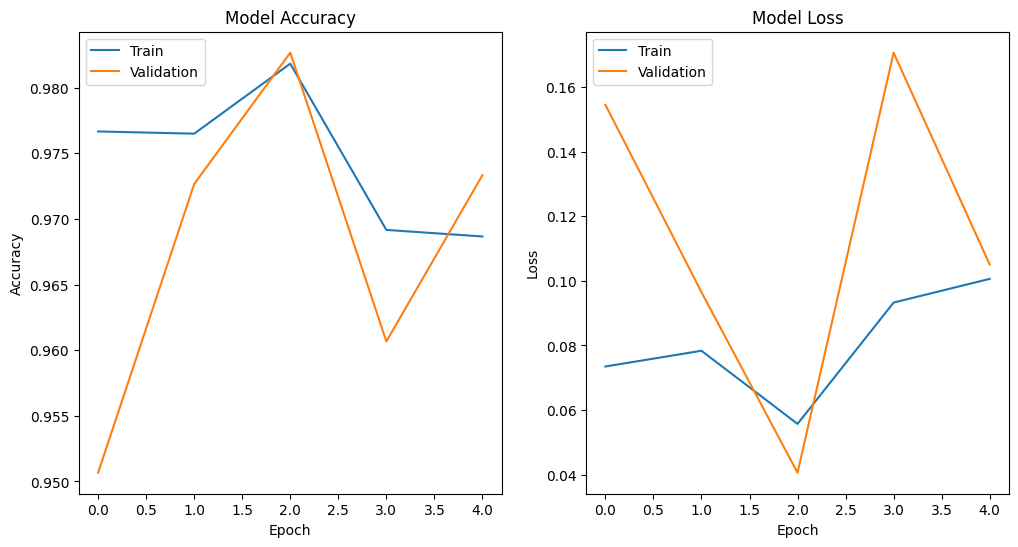

In [247]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ls.history['accuracy'])
plt.plot(ls.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ls.history['loss'])
plt.plot(ls.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

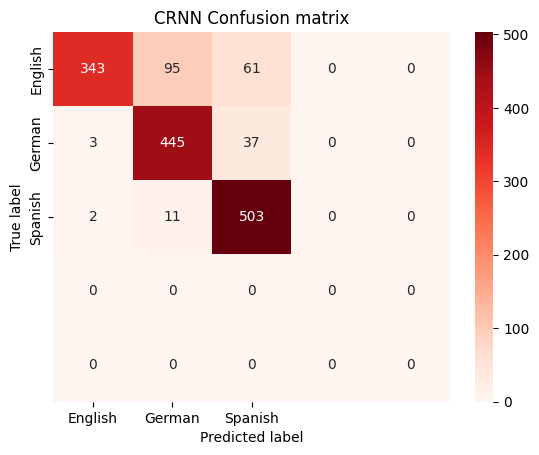

In [248]:
cmmm= confusion_matrix(np.argmax(y_test, axis=1), crnn_preds, labels=range(5))

sns.heatmap(cmm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CRNN Confusion matrix')
plt.show()

In [288]:
#Building CNN model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import SGD

# Define the CNN model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 output classes
])


# Define the learning rate
learning_rate = 0.001  

# Create the SGD optimizer with the specified learning rate
sgd_optimizer = SGD(learning_rate=learning_rate)


cnn_model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Print model summary
cnn_model.summary()


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_63 (Conv1D)          (None, 126, 64)           256       
                                                                 
 max_pooling1d_62 (MaxPooli  (None, 63, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_64 (Conv1D)          (None, 61, 128)           24704     
                                                                 
 max_pooling1d_63 (MaxPooli  (None, 30, 128)           0         
 ng1D)                                                           
                                                                 
 flatten_41 (Flatten)        (None, 3840)              0         
                                                                 
 dense_94 (Dense)            (None, 256)             

In [289]:
ls=cnn_model.fit(X_train,y_train,epochs=4,batch_size=16,validation_data=(X_test,y_test))

Epoch 1/4
375/375 [==============================] - 3s 6ms/step - loss: 0.8363 - accuracy: 0.6560 - precision: 0.7287 - recall: 0.5140 - auc: 0.8186 - val_loss: 0.5246 - val_accuracy: 0.8640 - val_precision: 0.9569 - val_recall: 0.7100 - val_auc: 0.9672
Epoch 2/4
375/375 [==============================] - 2s 5ms/step - loss: 0.4988 - accuracy: 0.8327 - precision: 0.8850 - recall: 0.7475 - auc: 0.9505 - val_loss: 0.3265 - val_accuracy: 0.9553 - val_precision: 0.9881 - val_recall: 0.8873 - val_auc: 0.9956
Epoch 3/4
375/375 [==============================] - 2s 5ms/step - loss: 0.3610 - accuracy: 0.8857 - precision: 0.9221 - recall: 0.8382 - auc: 0.9768 - val_loss: 0.2228 - val_accuracy: 0.9800 - val_precision: 0.9917 - val_recall: 0.9520 - val_auc: 0.9988
Epoch 4/4
375/375 [==============================] - 2s 5ms/step - loss: 0.2695 - accuracy: 0.9225 - precision: 0.9429 - recall: 0.8893 - auc: 0.9882 - val_loss: 0.1892 - val_accuracy: 0.9607 - val_precision: 0.9798 - val_recall: 0.938

In [290]:
cnn_model.evaluate(X_train, y_train)

188/188 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9493 - precision: 0.9704 - recall: 0.9192 - auc: 0.9954


[0.21082042157649994,
 0.9493333101272583,
 0.9704381227493286,
 0.9191666841506958,
 0.9953712224960327]

In [291]:
cnn_model.evaluate(X_test, y_test)

47/47 [==============================] - 0s 3ms/step - loss: 0.1892 - accuracy: 0.9607 - precision: 0.9798 - recall: 0.9380 - auc: 0.9973


[0.18916109204292297,
 0.9606666564941406,
 0.9798049926757812,
 0.9380000233650208,
 0.9972716569900513]

In [292]:
cnn_preds = np.argmax(crnn_model.predict(X_test), axis =  1)

47/47 [==============================] - 0s 5ms/step


In [293]:
cnn_preds = np.argmax(crnn_model.predict(X_test), axis =  1)

47/47 [==============================] - 0s 5ms/step


In [294]:
Testing_Audio=glob("C:/Users/myada/Downloads/archive(1)/Destination/es/*.flac")
ipd.Audio(Testing_Audio[10])

In [295]:
# Caculating the mfcc values
X,sample_rate=librosa.load(Testing_Audio[10])
mfcc=np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=128).T,axis=0)

In [296]:
# Z is the mfcc values for Spanish language. it contains Noise data audio
labels = ['English', 'German', 'Spanish']
print(labels)
z=mfcc
z = np.reshape(z, (1, 128))
prediction =cnn_model.predict(z)
print(prediction)

['English', 'German', 'Spanish']
1/1 [==============================] - 0s 70ms/step
[[0.05081465 0.05590739 0.89327794]]


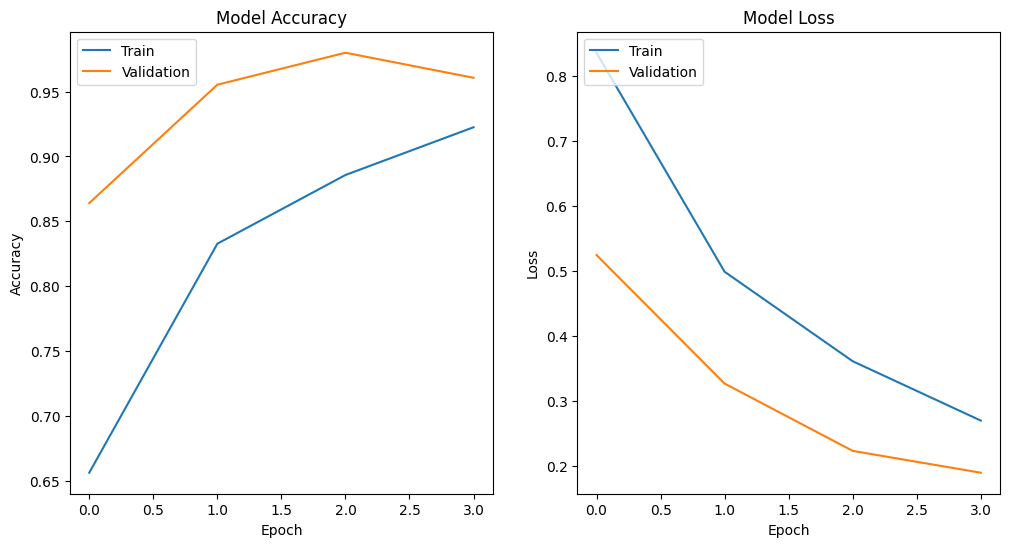

In [297]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ls.history['accuracy'])
plt.plot(ls.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(ls.history['loss'])
plt.plot(ls.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

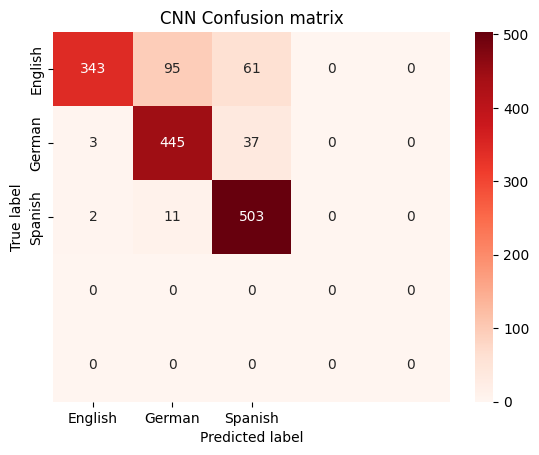

In [299]:
cmmm= confusion_matrix(np.argmax(y_test, axis=1), cnn_preds, labels=range(5))

sns.heatmap(cmm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN Confusion matrix')
plt.show()